# BirdCLEF by Pytorch - Model : Resnet18 construct by EK / Code edit : TY

## Module

In [ ]:
# Import necessary libraries
import os
import sys
import gc
import re
import math
import random
import warnings
from glob import glob
from pathlib import Path
from functools import partial
from typing import Any, Callable, List, Optional, Type, Union
from concurrent import futures

# Import scientific libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import librosa
from scipy import signal as sci_signal
from PIL import Image

# Import PyTorch and related libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torchvision.transforms as transforms
from torchvision.models import (resnet18, resnet34, resnet50, resnet101, resnet152,
                                 resnext50_32x4d, resnext101_32x8d, resnext101_64x4d,
                                 wide_resnet50_2, wide_resnet101_2)
import torchaudio

# Import Albumentations for data augmentation
import albumentations as albu
from albumentations.pytorch.transforms import ToTensorV2

# Import PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

# Import Scikit-learn for metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

# Setup device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Ignore warnings
warnings.filterwarnings(action='ignore')

print(f"Using device: {device}")

## Config & Set seeds

In [ ]:
class config:
    
    # == global config ==
    SEED = 42  # random seed
    DEVICE = 'cpu'  # device to be used
    MIXED_PRECISION = False  # whether to use mixed-16 precision
    OUTPUT_DIR = '/kaggle/working/'  # output folder
    
    # == data config ==
    DATA_ROOT = '/kaggle/input/birdclef-2024'  # root folder
    Load_DATA = False  # whether to load data from pre-processed dataset
    FS = 32000  # sample rate
    N_FFT = 1095  # n FFT of Spec.
    WIN_SIZE = 412  # WIN_SIZE of Spec.
    WIN_LAP = 100  # overlap of Spec.
    MIN_FREQ = 40  # min frequency
    MAX_FREQ = 15000  # max frequency
    
    # == model config ==
    MODEL_TYPE = 'resnet18'  # 모델 타입을 resnet18로 변경합니다.
    
    # == dataset config ==
    BATCH_SIZE = 64  # batch size of each step
    N_WORKERS = 4  # number of workers
    
    # == inference config ==
    CKPT_ROOT = '/kaggle/input/birdclef24-baseline-checkpoints'
    
    # == other config ==
    VISUALIZE = True  # whether to visualize data and batch
    
print('fix seed')
pl.seed_everything(config.SEED, workers=True)

## Model build by 익균

In [1]:
__all__ = [
    "ResNet",
    "ResNet18_Weights",
    "ResNet34_Weights",
    "ResNet50_Weights",
    "ResNet101_Weights",
    "ResNet152_Weights",
    "ResNeXt50_32X4D_Weights",
    "ResNeXt101_32X8D_Weights",
    "ResNeXt101_64X4D_Weights",
    "Wide_ResNet50_2_Weights",
    "Wide_ResNet101_2_Weights",
    "resnet18",
    "resnet34",
    "resnet50",
    "resnet101",
    "resnet152",
    "resnext50_32x4d",
    "resnext101_32x8d",
    "resnext101_64x4d",
    "wide_resnet50_2",
    "wide_resnet101_2",
]

# Example of an Image Classification Transform
ImageClassificationTransform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def _log_api_usage_once(obj):
    pass

def _ovewrite_named_param(kwargs, param, new_value):
    if param in kwargs:
        kwargs[param] = new_value
    return kwargs

def handle_legacy_interface(**kwargs):
    pass

_IMAGENET_CATEGORIES = ['cat', 'dog']  # Example categories, replace with actual categories if needed

class Weights:
    def __init__(self, path, transforms, meta):
        self.path = path
        self.transforms = transforms
        self.meta = meta

    def get_state_dict(self, progress=True, check_hash=True):
        state_dict = torch.load(self.path)
        return state_dict

class WeightsEnum:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

    def __getattr__(self, name):
        return self.__dict__[name]

def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )

def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class Bottleneck(nn.Module):
    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        num_classes: int = 1000,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        _log_api_usage_once(self)
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                f"or a 3-element tuple, got {replace_stride_with_dilation}"
            )
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck) and m.bn3.weight is not None:
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock) and m.bn2.weight is not None:
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        planes: int,
        blocks: int,
        stride: int = 1,
        dilate: bool = False,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

def _resnet(
    block: Type[Union[BasicBlock, Bottleneck]],
    layers: List[int],
    weights: Optional[WeightsEnum],
    progress: bool,
    **kwargs: Any,
) -> ResNet:
    if weights is not None:
        _ovewrite_named_param(kwargs, "num_classes", len(weights.meta["categories"]))

    model = ResNet(block, layers, **kwargs)

    if weights is not None:
        model.load_state_dict(weights.get_state_dict(progress=progress, check_hash=True))

    return model

_COMMON_META = {
    "min_size": (1, 1),
    "categories": _IMAGENET_CATEGORIES,
}

class ResNet18_Weights(WeightsEnum):
    LOCAL = Weights(
        # 사용해야되는 pth파일 경로
#         path="/kaggle/input/best-model-resnet18-by-iy/best_model.pth",
        path = "/kaggle/input/weight-v2/best_model_0611.pth",
        transforms=partial(transforms.Compose, [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]),
        meta={
            **_COMMON_META,
            "num_params": 11689512,
            "recipe": "https://github.com/pytorch/vision/tree/main/references/classification#resnet",
            "_metrics": {
                "ImageNet-1K": {
                    "acc@1": 69.758,
                    "acc@5": 89.078,
                }
            },
            "_ops": 1.814,
            "_file_size": 44.661,
            "_docs": """These weights reproduce closely the results of the paper using a simple training recipe.""",
        },
    )
    DEFAULT = LOCAL

## BirdModel edit by 태영

In [2]:
# LightningModule활용 BirdModel구축
## 코드 간결화 및 모듈화 지원
class BirdModel(pl.LightningModule):
    
    def __init__(self):
        super().__init__()
        
        
        # == loss function == : CrossEntropyLoss
        self.loss_fn = nn.CrossEntropyLoss()
        
        # == record ==
        self.validation_step_outputs = []
        
    def forward(self, images):
        return self.backbone(images)
    
    def configure_optimizers(self):
        
        # == define optimizer == : Adam
        model_optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, self.parameters()),
            lr=config.LR,
            weight_decay=config.WEIGHT_DECAY
        )
        
        # == define learning rate scheduler ==
        lr_scheduler = CosineAnnealingWarmRestarts(
            model_optimizer,
            T_0=config.EPOCHS,
            T_mult=1,
            eta_min=1e-6,
            last_epoch=-1
        )
        
        return {
            'optimizer': model_optimizer,
            'lr_scheduler': {
                'scheduler': lr_scheduler,
                'interval': 'epoch',
                'monitor': 'val_loss',
                'frequency': 1
            }
        }
    # train
    def training_step(self, batch, batch_idx):
        
        # == obtain input and target ==
        image, target = batch
        image = image.to(self.device)
        target = target.to(self.device)
        
        # == pred ==
        y_pred = self(image)
        
        # == compute loss ==
        train_loss = self.loss_fn(y_pred, target)
        
        # == record ==
        self.log('train_loss', train_loss, True)
        
        return train_loss
    # val
    def validation_step(self, batch, batch_idx):
        
        # == obtain input and target ==
        image, target = batch
        image = image.to(self.device)
        target = target.to(self.device)
        
        # == pred ==
        with torch.no_grad():
            y_pred = self(image)
            
        self.validation_step_outputs.append({"logits": y_pred, "targets": target})
    # dataloader
    ## train
    def train_dataloader(self):
        return self._train_dataloader
    ## val
    def validation_dataloader(self):
        return self._validation_dataloader
    
    def on_validation_epoch_end(self):
        
        # = merge batch data =
        outputs = self.validation_step_outputs
        
        output_val = nn.Softmax(dim=1)(torch.cat([x['logits'] for x in outputs], dim=0)).cpu().detach()
        target_val = torch.cat([x['targets'] for x in outputs], dim=0).cpu().detach()
        
        # = compute validation loss =
        val_loss = self.loss_fn(output_val, target_val)
        
        # target to one-hot
        target_val = torch.nn.functional.one_hot(target_val, len(label_list))
        
        # = val with ROC AUC =
        gt_df = pd.DataFrame(target_val.numpy().astype(np.float32), columns=label_list)
        pred_df = pd.DataFrame(output_val.numpy().astype(np.float32), columns=label_list)
        
        gt_df['id'] = [f'id_{i}' for i in range(len(gt_df))]
        pred_df['id'] = [f'id_{i}' for i in range(len(pred_df))]
        
        val_score = score(gt_df, pred_df, row_id_column_name='id')
        
        self.log("val_score", val_score, True)
        
        return {'val_loss': val_loss, 'val_score': val_score}

## Label 추가

In [1]:
# labels
label_list = sorted(os.listdir(os.path.join(config.DATA_ROOT, 'train_audio')))
label_id_list = list(range(len(label_list)))
label2id = dict(zip(label_list, label_id_list))
id2label = dict(zip(label_id_list, label_list))

NameError: name 'os' is not defined

# Functions of Inference Loop

## 데이터 전처리

In [ ]:
# 오디오 -> 스펙토그램 / min-max scaling
def oog2spec_via_scipy(audio_data):
    # handles NaNs
    mean_signal = np.nanmean(audio_data)
    audio_data = np.nan_to_num(audio_data, nan=mean_signal) if np.isnan(audio_data).mean() < 1 else np.zeros_like(audio_data)
    
    # to spec.
    frequencies, times, spec_data = sci_signal.spectrogram(
        audio_data, 
        fs=config.FS, 
        nfft=config.N_FFT, 
        nperseg=config.WIN_SIZE, 
        noverlap=config.WIN_LAP, 
        window='hann'
    )
    
    # Filter frequency range
    valid_freq = (frequencies >= config.MIN_FREQ) & (frequencies <= config.MAX_FREQ)
    spec_data = spec_data[valid_freq, :]
    
    # Log
    spec_data = np.log10(spec_data + 1e-20)
    
    # min/max normalize
    spec_data = spec_data - spec_data.min()
    spec_data = spec_data / spec_data.max()
    
    return spec_data

## 데이터 로딩

In [ ]:
all_bird_data = dict()

if len(glob(f'{config.DATA_ROOT}/test_soundscapes/*.ogg')) > 0:
    ogg_file_paths = glob(f'{config.DATA_ROOT}/test_soundscapes/*.ogg')
else:
    ogg_file_paths = sorted(glob(f'{config.DATA_ROOT}/unlabeled_soundscapes/*.ogg'))[:10]

for i, file_path in tqdm(enumerate(ogg_file_paths)):
    row_id = re.search(r'/([^/]+)\.ogg$', file_path).group(1)
    audio_data, _ = librosa.load(file_path, sr=config.FS)
    
    spec = oog2spec_via_scipy(audio_data)
    
    pad = 512 - (spec.shape[1] % 512)
    if pad > 0:
        spec = np.pad(spec, ((0,0), (0,pad)))
    
    spec = spec.reshape(512,-1,512).transpose([0, 2, 1])
    spec = cv2.resize(spec, (256, 256), interpolation=cv2.INTER_AREA)
    
    for j in range(48):
        all_bird_data[f'{row_id}_{(j+1)*5}'] = spec[:, :, j]


## 데이터셋 정의

In [ ]:
class BirdDataset(torch.utils.data.Dataset):
    
    def __init__(
        self,
        bird_data,
        augmentation=None,
    ):
        super().__init__()
        self.bird_data = bird_data
        self.keys_list = list(bird_data.keys())
        self.augmentation = augmentation
    
    def __len__(self):
        return len(self.bird_data)
    
    def __getitem__(self, index):
        
        _spec = self.bird_data[self.keys_list[index]]
        
        if self.augmentation is not None:
            _spec = self.augmentation(image=_spec)['image'] 
        
        # 채널 수를 1에서 3으로 변경합니다.
        _spec = np.stack([_spec]*3, axis=0)
        
        return torch.tensor(_spec, dtype=torch.float32)

## 데이터 증강 : Augmentation

In [ ]:
def get_transforms(_type):
    
    if (_type == 'test'):
        return albu.Compose([])
# def get_transforms(_type):
#     if (_type == 'test'):
#         return albu.Compose([albu.VerticalFlip(p=0.5),
#                              albu.HorizontalFlip(p=0.5),
#                              albu.RandomCrop(width=170, height=200, p=1),# 시간 : 약 0.35, 주파수 : 약 0.20적용
#                              albu.Resize(256, 256)], p = 1)

## 배치 시각화

In [ ]:
def show_batch(ds, row=2, col=2):
    fig = plt.figure(figsize=(6, 6))
    img_index = np.random.randint(0, len(ds)-1, row*col)
    
    for i in range(len(img_index)):
        img = dummy_dataset[img_index[i]]
        
        if isinstance(img, torch.Tensor):
            img = img.detach().numpy()
        
        ax = fig.add_subplot(2, 2, i + 1, xticks=[], yticks=[])
        ax.imshow(img.transpose(1, 2, 0), cmap='jet')  # 이미지를 올바르게 표시하기 위해 전치합니다.
        ax.set_title(f'ID: {img_index[i]}')
    
    plt.tight_layout()
    plt.show()

dummy_dataset = BirdDataset(all_bird_data, get_transforms('test'))

test_input = dummy_dataset[0]
# print(test_input.detach().numpy().shape)

if config.VISUALIZE:
    show_batch(dummy_dataset)

del dummy_dataset
gc.collect()

## 예측 수행

fix seed


0it [00:00, ?it/s]

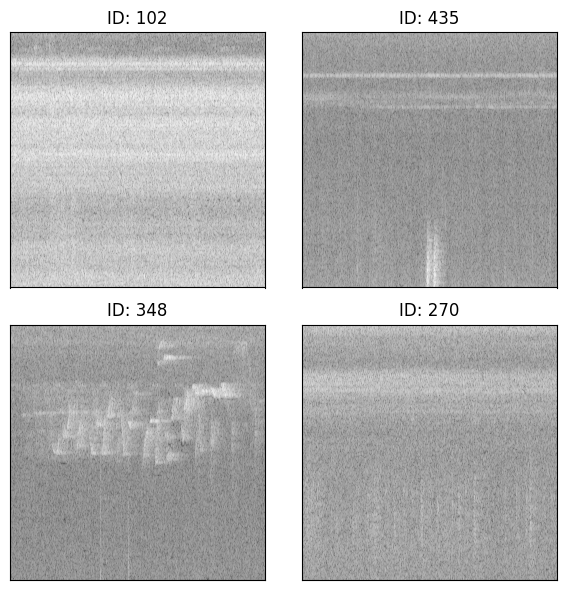

  0%|          | 0/8 [00:00<?, ?it/s]

Submissionn shape: (480, 183)


,row_id,asbfly,ashdro1,ashpri1,ashwoo2,asikoe2,asiope1,aspfly1,aspswi1,barfly1,...,whbwoo2,whcbar1,whiter2,whrmun,whtkin2,woosan,wynlau1,yebbab1,yebbul3,zitcis1
0,1000170626_5,0.016947,0.003628,0.000901,0.002660,0.020977,0.002435,0.003866,0.001983,0.001563,...,0.010156,0.005569,0.001279,0.002702,0.005626,0.006958,0.001588,0.005309,0.003276,0.003435
1,1000170626_10,0.016754,0.004130,0.000977,0.003223,0.016591,0.002695,0.004273,0.002227,0.001436,...,0.008750,0.004552,0.001470,0.002482,0.006242,0.010220,0.001523,0.005568,0.001935,0.004948
2,1000170626_15,0.011937,0.003089,0.001124,0.001809,0.017077,0.002696,0.003153,0.001875,0.000827,...,0.006078,0.004886,0.001318,0.002488,0.007473,0.015201,0.001054,0.004338,0.001319,0.003341
3,1000170626_20,0.015015,0.003150,0.001032,0.001998,0.019187,0.002559,0.003723,0.001699,0.001173,...,0.006035,0.004246,0.001055,0.003144,0.007709,0.011498,0.001206,0.003329,0.001492,0.004410
4,1000170626_25,0.011766,0.003109,0.001326,0.002355,0.013510,0.002740,0.003653,0.001714,0.000924,...,0.006084,0.003803,0.001194,0.002359,0.005063,0.014234,0.001336,0.006607,0.001267,0.004123


In [3]:
def predict(data_loader, model):
    model.to(config.DEVICE)
    model.eval()
    pred = []
    for batch in tqdm(data_loader):
        with torch.no_grad():
            x = batch.to(config.DEVICE)
            outputs = model(x)
            outputs = nn.Softmax(dim=1)(outputs)
        pred.append(outputs.detach().cpu())
    
    pred = torch.cat(pred, dim=0).cpu().detach()
    
    return pred.numpy().astype(np.float32)

# ckpt_list = glob(f'{config.CKPT_ROOT}/*.ckpt')
# print(f'find {len(ckpt_list)} ckpts in {config.CKPT_ROOT}.')

ckpt_list = [f'/kaggle/input/birdclef24-baseline-checkpoints/fold_0.ckpt']

predictions = []

for ckpt in ckpt_list:
    
    # == init model ==
    bird_model = resnet18(pretrained=False)  # efficientnet 대신 resnet18을 사용합니다.
    bird_model.fc = nn.Linear(512, len(label_list))  # 마지막 레이어를 데이터셋에 맞게 수정합니다.
    
    # == load ckpt ==
    bird_model.load_state_dict(torch.load('/kaggle/input/weight-v2/best_model_0611.pth', map_location=torch.device('cpu')))
    
    # == create dataset & dataloader ==
    test_dataset = BirdDataset(all_bird_data, get_transforms('test'))
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=config.BATCH_SIZE,
        num_workers=config.N_WORKERS,
        shuffle=False,
        drop_last=False
    )
    
    predictions.append(predict(test_loader, bird_model))
    gc.collect()

predictions = np.mean(predictions, axis=0)

sub_pred = pd.DataFrame(predictions, columns=label_list)
sub_id = pd.DataFrame({'row_id': list(all_bird_data.keys())})

sub = pd.concat([sub_id, sub_pred], axis=1)

sub.to_csv('submission.csv',index=False)
print(f'Submissionn shape: {sub.shape}')
sub.head(5)


In [4]:
sub

,row_id,asbfly,ashdro1,ashpri1,ashwoo2,asikoe2,asiope1,aspfly1,aspswi1,barfly1,...,whbwoo2,whcbar1,whiter2,whrmun,whtkin2,woosan,wynlau1,yebbab1,yebbul3,zitcis1
0,1000170626_5,0.016947,0.003628,0.000901,0.002660,0.020977,0.002435,0.003866,0.001983,0.001563,...,0.010156,0.005569,0.001279,0.002702,0.005626,0.006958,0.001588,0.005309,0.003276,0.003435
1,1000170626_10,0.016754,0.004130,0.000977,0.003223,0.016591,0.002695,0.004273,0.002227,0.001436,...,0.008750,0.004552,0.001470,0.002482,0.006242,0.010220,0.001523,0.005568,0.001935,0.004948
2,1000170626_15,0.011937,0.003089,0.001124,0.001809,0.017077,0.002696,0.003153,0.001875,0.000827,...,0.006078,0.004886,0.001318,0.002488,0.007473,0.015201,0.001054,0.004338,0.001319,0.003341
3,1000170626_20,0.015015,0.003150,0.001032,0.001998,0.019187,0.002559,0.003723,0.001699,0.001173,...,0.006035,0.004246,0.001055,0.003144,0.007709,0.011498,0.001206,0.003329,0.001492,0.004410
4,1000170626_25,0.011766,0.003109,0.001326,0.002355,0.013510,0.002740,0.003653,0.001714,0.000924,...,0.006084,0.003803,0.001194,0.002359,0.005063,0.014234,0.001336,0.006607,0.001267,0.004123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,1001358022_220,0.013788,0.002112,0.001363,0.001542,0.010170,0.003202,0.003489,0.001794,0.001068,...,0.004716,0.002594,0.002373,0.003265,0.005949,0.020925,0.000873,0.005451,0.000633,0.004144
476,1001358022_225,0.007888,0.003485,0.001487,0.002352,0.013809,0.002406,0.003774,0.001816,0.001048,...,0.005436,0.004224,0.001451,0.002745,0.006529,0.016950,0.001051,0.004775,0.000878,0.002855
477,1001358022_230,0.006875,0.003847,0.001756,0.002399,0.008807,0.002146,0.004267,0.001896,0.001050,...,0.005022,0.002662,0.001529,0.003428,0.009178,0.012543,0.000935,0.005311,0.000711,0.004170
478,1001358022_235,0.010178,0.003170,0.001808,0.002447,0.013929,0.002569,0.003747,0.002109,0.001390,...,0.007282,0.005309,0.001876,0.003534,0.009459,0.014502,0.001266,0.004606,0.000965,0.004042
